In [1]:
import yt
import ytree
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler

In [10]:
# Load ytree arbor and array of redshifts.
a = ytree.load('full_arbor/full_arbor.h5')
redshifts = np.load('stored_arrays/ytree_redshifts.npy')

# Set the maximum redshift to be included in analysis.
max_redshift = 12.

# Identify any bad datasets.
bad_redshifts = np.array([redshifts[23], redshifts[30]])
# Create mask to exlude high redshifts and bad redshifts.
mask = (redshifts < max_redshift)*[redshift not in bad_redshifts for redshift in redshifts]

# Update redshift array to include only redshifts of interest.
redshifts = redshifts[mask]

In [12]:
# Set minimum mass threshold for virialization. ~250 DM particles.
min_mass_threshold = 5e5

# Select all Pop III progenitor halos.
hlist = a.select_halos("tree['tree', 'is_popiii_progenitor'] == 1", fields=['is_popiii_progenitor'])
# Select only Pop III progenitor halos that are in redshifts of interest.
progenitors = np.array([halo for halo in hlist if halo['redshift'] in redshifts])

print('Number of progenitor halos:', len(progenitors))

# Set the overall minimum mass to be the minimum of the Pop III progenitor halo masses.
masses = [halo['sphere_mass'] for halo in progenitors]
min_mass = np.min(masses)

# Select all no-stars above the minimum mass threshold.
hlist = a.select_halos("(tree['tree', 'sphere_stellar_mass'] == 0) & (tree['tree', 'mass'] > {})"\
                       .format(min_mass_threshold), fields=['sphere_stellar_mass', 'mass'])
# Select only no-star halos that are in redshifts of interest.
no_star_halos = np.array([halo for halo in hlist if halo['redshift'] in redshifts])

print('Number of no-star halos:', len(no_star_halos))

# Set the overall maximum mass to be the maximum of the no-star halo masses.
masses = [halo['sphere_mass'] for halo in no_star_halos]
max_mass = np.max(masses)

print('Minimum mass (Msun):', min_mass)
print('Maximum mass (Msun):', max_mass)

# Select halos within min_mass and max_mass.
# Must be above minimum mass threshold for virialization.
# Must either have no stars or be a Pop III progenitor halo.
hlist = a.select_halos("(tree['tree', 'mass'] > {}) & (tree['tree', 'sphere_mass'] > {}) & \
                        (tree['tree', 'sphere_mass'] < {}) & ((tree['tree', 'sphere_stellar_mass'] == 0) | \
                        (tree['tree', 'is_popiii_progenitor'] == 1))"\
                       .format(min_mass_threshold, min_mass, max_mass), fields=['mass', 'sphere_mass'])

# Select only halos that are in the redshifts of interest.
halos = np.array([halo for halo in hlist if halo['redshift'] in redshifts])

Selecting halos: 100%|██████████| 4681/4681 [00:00<00:00, 12926.10it/s]


Number of progenitor halos: 55


Selecting halos: 100%|██████████| 4681/4681 [00:00<00:00, 4723.02it/s]


Number of no-star halos: 17677
Minimum mass (Msun): 4358867.967511095
Maximum mass (Msun): 38861821.560513675


Getting fields:   0%|          | 0/4681 [00:00<?, ?it/s]/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
Selecting halos: 100%|██████████| 4681/4681 [00:02<00:00, 2257.14it/s]


In [18]:
# Create arrays of relevant parameters for each halo.

fields = ['sphere_mass', 'sphere_mass_growth', 'mass_growth_sign', 'sphere_mass_growth_derivative', \
          'growth_derivative_sign', 'number_of_mergers', 'neighbor_distance', 'sphere_J21_LW']


# Record the number of halos and features that will be in the data array
num_halos = len(halos)
num_features = len(fields)

# Create arrays to store data for each halo and to 
halo_data_array = np.zeros((num_halos, num_features))
good_data = np.ones(num_halos, dtype=bool)

# Iterate through each halo to add its features to the data array.
for i, halo in enumerate(halos):
    # Iterate through each field to be included to add to the data array.
    for j, field in enumerate(fields):
        # Don't take the log of a redshift
        if field == 'redshift' or field == 'number_of_mergers':
            halo_data_array[i, j] = halo[field]
        elif field == 'mass_growth_sign':
            halo_data_array[i, j] = np.sign(halo['sphere_mass_growth'])
        elif field == 'growth_derivative_sign':
            halo_data_array[i, j] = np.sign(halo['sphere_mass_growth_derivative'])
        # Take log of absolute value of all other fields.
        else:
            halo_data_array[i, j] = np.log10(np.abs(halo[field]))
            # If a field is 0, it is a new halo and has no information about its growth history
            if halo[field] == 0.:
                good_data[i] = False
                
# Do analysis only on good data.
halo_data_array = halo_data_array[good_data]

scaler = StandardScaler()
X = scaler.fit_transform(halo_data_array)
y = np.array([halo['is_popiii_progenitor'] for halo in halos], dtype=int)[good_data]

print('Number of no-star halos:', len(y[y==0]))
print('Number of Pop III progenitors:', len(y[y==1]))

/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Number of no-star halos: 1810
Number of Pop III progenitors: 52


In [19]:
def gaussian_fit(halo_data_array):

    num_variables = np.shape(halo_data_array)[0]

    # Create the covariance matrix for the given variables
    Sigma = np.cov(halo_data_array)
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)

    return 1/np.sqrt((2*np.pi)**num_variables*Sigma_det)\
            *np.exp(-.5*np.diagonal(np.matmul(halo_data_array.T, np.matmul(Sigma_inv, halo_data_array))))

In [20]:
def mahalanobis_distance(halo_data_array):
    
    Sigma = np.cov(halo_data_array)
    Sigma_inv = np.linalg.inv(Sigma)
    
    return np.diagonal(np.matmul(halo_data_array.T, np.matmul(Sigma_inv, halo_data_array)))

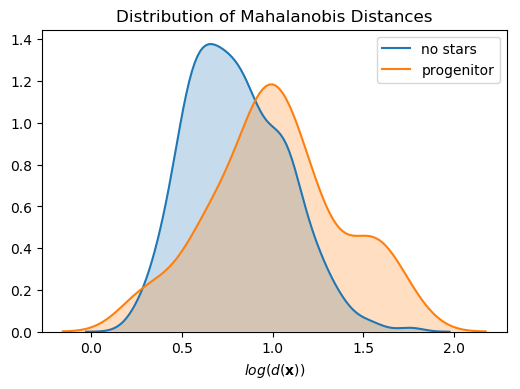

In [22]:
#fit = mahalanobis_distance(X.T)
fit = np.log10(mahalanobis_distance(X.T))

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

sns.kdeplot(fit[y==0], shade=True, label='no stars')
sns.kdeplot(fit[y==1], shade=True, label='progenitor')
#plt.xlim(-16, 0)
plt.xlabel(r'$log (d(\mathbf{x}))$')
plt.legend()
plt.title('Distribution of Mahalanobis Distances')
plt.savefig('mahalanobis_distances.png')
plt.show()